In [58]:
import os
import numpy as np
import pandas as pd
import json
import warnings
from copy import deepcopy
import torch
from torch.utils.data import DataLoader
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForCausalLM, Pipeline, BitsAndBytesConfig
from torchmetrics.functional import calibration_error

# plotting
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve, CalibrationDisplay
import seaborn as sns
plt.rcParams["pdf.fonttype"]=42
plt.rcParams["font.size"]=14
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["savefig.transparent"] = False
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["axes.spines.right"]=False
plt.rcParams["axes.spines.top"]=False
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.1
plt.rcParams["axes.labelsize"] = 16
wharton_colors = json.load(open("wharton-colors-distinct.json", "r"))
wharton_pal = sns.color_palette(wharton_colors.values(), n_colors=len(wharton_colors))
sequential_wharton = sns.color_palette(
    f"blend:{wharton_colors['College Gray']},{wharton_colors['Wharton Blue']}",
    as_cmap=True
    )
# set matplotlib color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=wharton_pal)

# progress bar for notebooks
from tqdm.notebook import tqdm

# check if HF_HOME is set
assert "HF_HOME" in os.environ, "HF_HOME is not set"
print("models live at: ", os.environ["HF_HOME"])

# check if cuda is available, if not, use mps (if available)
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
    warnings.warn("No CUDA or MPS device available, using CPU")
print("using device: ", device)

models live at:  /shared_data0/jrudoler/.cache/huggingface/
using device:  cuda


## Create data for learning basic functions 

In [ ]:
# Load model directly
model_id = "meta-llama/Llama-3.2-1B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id)
model.generation_config.pad_token_id = tokenizer.eos_token_id
model.generation_config.return_dict_in_generate = True
model.generation_config.output_scores = True

In [ ]:
# pipe = pipeline(
#     "text-generation",
#     model=model,
#     tokenizer=tokenizer,
#     torch_dtype=torch.bfloat16,
#     device=device,
# )

In [4]:
# Generate random data for OLS


def generate_dataset(n_samples: int, f, x_std: float, noise_std: float):
    x = np.random.randn(n_samples) * x_std
    y = f(x) + np.random.randn(n_samples) * noise_std
    return pd.DataFrame({"x": x, "y": y})


def linear_model(x, slope: float, intercept: float):
    return slope * x + intercept


def quadratic_model(x, a: float, b: float, c: float):
    return a * x**2 + b * x + c


def log_model(x, a: float, b: float):
    return a * np.log(x) + b


def exp_model(x, a: float, b: float):
    return a * np.exp(b * x)


# Example usage
n_samples = 100
slope = 3
intercept = 2
x_std = 1
noise_std = 0.05

dataset = generate_dataset(n_samples, lambda x: linear_model(x, slope, intercept), x_std, noise_std)
print(dataset.head())

          x         y
0 -0.671339  0.023600
1 -1.496643 -2.490145
2  1.388899  6.182442
3 -1.120351 -1.389129
4 -0.501480  0.554781


In [5]:
# helper function to create a list of messages from a dataset
def create_few_shot_messages(dataset: pd.DataFrame):
    """
    Given a dataframe with columns "x" and "y", create a list of messages for the model.
    If there are m rows, the first m-1 rows will be used as few-shot examples
    and the last row will be the target example.
    """
    messages = []
    for i, row in dataset.iterrows():
        messages.append({"role": "user", "content": f"x = {row['x']}; y = ?"})
        messages.append({"role": "assistant", "content": f"{row['y']}"})
    return messages


def create_query_messages(dataset: pd.DataFrame):
    messages = []
    for i, row in dataset.iterrows():
        messages.append({"role": "user", "content": f"x = {row['x']}; y = ?"})
    return messages


dataset = generate_dataset(n_samples, lambda x: linear_model(x, slope, intercept), x_std, noise_std)
few_shot_messages = create_few_shot_messages(dataset)
query_messages = create_query_messages(dataset)
print(few_shot_messages)
print(query_messages)

[{'role': 'user', 'content': 'x = 1.2984149620645673; y = ?'}, {'role': 'assistant', 'content': '5.884255584027905'}, {'role': 'user', 'content': 'x = 1.2257159848465278; y = ?'}, {'role': 'assistant', 'content': '5.706293890663671'}, {'role': 'user', 'content': 'x = 1.0479860804142018; y = ?'}, {'role': 'assistant', 'content': '5.160517980980212'}, {'role': 'user', 'content': 'x = -0.4344106926623581; y = ?'}, {'role': 'assistant', 'content': '0.6529566556791584'}, {'role': 'user', 'content': 'x = -0.43699356685626717; y = ?'}, {'role': 'assistant', 'content': '0.5769598873613061'}, {'role': 'user', 'content': 'x = -0.2536858491356421; y = ?'}, {'role': 'assistant', 'content': '1.2028505722472371'}, {'role': 'user', 'content': 'x = -1.6949911125100416; y = ?'}, {'role': 'assistant', 'content': '-3.2025075793292466'}, {'role': 'user', 'content': 'x = 1.2546000405742777; y = ?'}, {'role': 'assistant', 'content': '5.7696817793460795'}, {'role': 'user', 'content': 'x = -0.9749501354738932

In [14]:
messages = few_shot_messages + query_messages[0:1]
pipe.model.generation_config.pad_token_id = tokenizer.eos_token_id
pipe.model.generation_config.return_dict_in_generate = True
pipe.model.generation_config.output_scores = True
outputs = pipe(
    messages,
    max_length=5000,
    pad_token_id=tokenizer.eos_token_id,
)
print(messages[-1])
print(outputs[0])

{'role': 'user', 'content': 'x = 1.2984149620645673; y = ?'}
{'generated_text': [{'role': 'user', 'content': 'x = 1.2984149620645673; y = ?'}, {'role': 'assistant', 'content': '5.884255584027905'}, {'role': 'user', 'content': 'x = 1.2257159848465278; y = ?'}, {'role': 'assistant', 'content': '5.706293890663671'}, {'role': 'user', 'content': 'x = 1.0479860804142018; y = ?'}, {'role': 'assistant', 'content': '5.160517980980212'}, {'role': 'user', 'content': 'x = -0.4344106926623581; y = ?'}, {'role': 'assistant', 'content': '0.6529566556791584'}, {'role': 'user', 'content': 'x = -0.43699356685626717; y = ?'}, {'role': 'assistant', 'content': '0.5769598873613061'}, {'role': 'user', 'content': 'x = -0.2536858491356421; y = ?'}, {'role': 'assistant', 'content': '1.2028505722472371'}, {'role': 'user', 'content': 'x = -1.6949911125100416; y = ?'}, {'role': 'assistant', 'content': '-3.2025075793292466'}, {'role': 'user', 'content': 'x = 1.2546000405742777; y = ?'}, {'role': 'assistant', 'conte

In [5]:
def prompt_and_predict(messages: list[dict], pipeline: Pipeline):
    pipeline.model.generation_config.pad_token_id = pipeline.tokenizer.eos_token_id
    pipeline.model.generation_config.return_dict_in_generate = True
    outputs = pipeline(messages, max_length=5000, pad_token_id=pipeline.tokenizer.eos_token_id, output_scores=True)
    return outputs  # [0]["generated_text"][-1]

In [80]:
ols = LinearRegression()
ols.fit(dataset["x"].values.reshape(-1, 1), dataset["y"].values)

ols.predict(dataset["x"].iloc[-1].reshape(1, -1))

array([1.17567767])

In [104]:
res = prompt_and_predict(few_shot_messages + query_messages[0:1], pipe)

In [107]:
res[0]

{'generated_text': [{'role': 'user',
   'content': 'x = -0.45903432938493827; y = ?'},
  {'role': 'assistant', 'content': '0.6400286257124784'},
  {'role': 'user', 'content': 'x = -0.7640071102714826; y = ?'},
  {'role': 'assistant', 'content': '-0.3166311849470841'},
  {'role': 'user', 'content': 'x = 2.39709748832622; y = ?'},
  {'role': 'assistant', 'content': '9.193544841312868'},
  {'role': 'user', 'content': 'x = -0.5033711887173068; y = ?'},
  {'role': 'assistant', 'content': '0.5073557515539322'},
  {'role': 'user', 'content': 'x = 0.37005520438959516; y = ?'},
  {'role': 'assistant', 'content': '3.180338410926132'},
  {'role': 'user', 'content': 'x = 0.520129111076402; y = ?'},
  {'role': 'assistant', 'content': '3.4983364943523214'},
  {'role': 'user', 'content': 'x = -1.4774222656568894; y = ?'},
  {'role': 'assistant', 'content': '-2.3957641491933366'},
  {'role': 'user', 'content': 'x = -0.28323129890452364; y = ?'},
  {'role': 'assistant', 'content': '1.0953330439664344'}

In [94]:
input = tokenizer.encode("x = 1; y = ?", return_tensors="pt").to(device)
model.generate(input, max_new_tokens=256, output_scores=True)
# print(tokenizer.decode([-1]))


GenerateDecoderOnlyOutput(sequences=tensor([[128000,     87,    284,    220,     16,     26,    379,    284,    949,
             26,   1167,    284,    865,    489,    379,    280,     88,    284,
            220,     20,     26,   1167,    284,    865,    489,    379,    280,
             88,    284,    220,    605,     26,   1167,    284,    865,    489,
            379,    280,     88,    284,    220,    508,     26,   1167,    284,
            865,    489,    379,    280,     88,    284,    220,    966,     26,
           1167,    284,    865,    489,    379,    280,     88,    284,    220,
           1272,     26,   1167,    284,    865,    489,    379,    280,     88,
            284,    220,   1135,     26,   1167,    284,    865,    489,    379,
            280,     88,    284,    220,   1399,     26,   1167,    284,    865,
            489,    379,    280,     88,    284,    220,   2031,     26,   1167,
            284,    865,    489,    379,    280,     88,    284,    220, 

In [73]:
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

few_shot_messages = create_few_shot_messages(train_dataset)
query_messages = create_query_messages(test_dataset)

for i, test_row in test_dataset.reset_index().iterrows():
    print(i, query_messages[i : i + 1])
    full_prompt_messages = few_shot_messages + query_messages[i : i + 1]
    pred = prompt_and_predict(full_prompt_messages, pipe)
    print(pred)
    print(f"x = {test_row['x']}; y = {test_row['y']}; pred = {pred}")


0 [{'role': 'user', 'content': 'x = -1.5047226363170778; y = ?'}]
{'role': 'assistant', 'content': '-2.1610111244455165'}
x = -1.5047226363170778; y = -2.457422877718286; pred = {'role': 'assistant', 'content': '-2.1610111244455165'}
1 [{'role': 'user', 'content': 'x = -0.9317807036702849; y = ?'}]
{'role': 'assistant', 'content': '-0.6956379113301794'}
x = -0.9317807036702849; y = -0.8476896227162707; pred = {'role': 'assistant', 'content': '-0.6956379113301794'}
2 [{'role': 'user', 'content': 'x = -0.04854387364964442; y = ?'}]
{'role': 'assistant', 'content': '1.9119265559560114'}
x = -0.04854387364964442; y = 1.8174565677505468; pred = {'role': 'assistant', 'content': '1.9119265559560114'}
3 [{'role': 'user', 'content': 'x = 1.1076373389582772; y = ?'}]
{'role': 'assistant', 'content': '5.33478610955586'}
x = 1.1076373389582772; y = 5.269385592413651; pred = {'role': 'assistant', 'content': '5.33478610955586'}
4 [{'role': 'user', 'content': 'x = -0.46746945950087276; y = ?'}]
{'rol

## SST-2

In [2]:
## NOTE LLAMA HAS THE FOLLOWING DEFAULT CONFIG:
# {
#   "_from_model_config": true,
#   "bos_token_id": 128000,
#   "eos_token_id": 128001,
#   "transformers_version": "4.45.0.dev0",
#   "do_sample": true,
#   "temperature": 0.6,
#   "top_p": 0.9
# }

In [4]:
###SST-2
import polars as pl
from data_handling import create_few_shot_sst2_messages, SST2Dataset
from classify_sst2 import load_sst2_data

sst2_train, sst2_test = load_sst2_data()

In [31]:
# Load model directly
model_id = "mistralai/Mistral-7B-Instruct-v0.3"
# model_id = "meta-llama/Llama-3.2-3B-Instruct"
# use 8-bit quantization
quantization_config = BitsAndBytesConfig(load_in_8bit=True)
model = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto", quantization_config=quantization_config)
# left padding for generation
# model = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto", torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model_id, padding_side="left", add_prefix_space=False)
# if "Mistral" in model_id:
#     with open("chat_templates/mistral-chat-template.jinja", "r") as f:
#         tokenizer.chat_template = f.read()
print("Original model.generation_config:\n", model.generation_config)
tokenizer.pad_token_id = tokenizer.eos_token_id
model.generation_config.pad_token_id = tokenizer.eos_token_id
model.generation_config.return_dict_in_generate = True
model.generation_config.output_scores = True
model.generation_config.do_sample = False
model.generation_config.temperature = None
model.generation_config.top_p = None
print("Updated model.generation_config:\n", model.generation_config)

print("tokenizer.pad_token_id: ", tokenizer.pad_token_id)
print("tokenizer.eos_token_id: ", tokenizer.eos_token_id)

# if torch.cuda.device_count() > 1:
#     print("Using multiple GPUs!")
#     model = DataParallel(model)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Original model.generation_config:
 GenerationConfig {
  "bos_token_id": 1,
  "eos_token_id": 2
}

Updated model.generation_config:
 GenerationConfig {
  "bos_token_id": 1,
  "eos_token_id": 2,
  "output_scores": true,
  "pad_token_id": 2,
  "return_dict_in_generate": true,
  "temperature": null,
  "top_p": null
}

tokenizer.pad_token_id:  2
tokenizer.eos_token_id:  2


In [32]:
config = {
    "batch_size": 4,
    "seed": 42,
    "n_context": 4,  # 500
    "n_target": 100,  # 500
}
context_samples = sst2_train.sample(config["n_context"], seed=config["seed"])
target_samples = sst2_test.sample(config["n_target"], seed=config["seed"])
target_messages = create_few_shot_sst2_messages(context_samples, target_samples)

In [34]:
tokenizer.apply_chat_template(target_messages[0:5], tokenize=False, add_generation_prompt=False, padding=True)

["<s>[INST] 's just tediously bad , something to be fully forgotten [/INST] 0</s>[INST] it asks nothing of the audience other than to sit back and enjoy a couple of great actors hamming it up . [/INST] 1</s>[INST] confidently orchestrated , aesthetically and sexually [/INST] 1</s>[INST] at cheapening it [/INST] 0</s>[INST] You will classify the given text with label 0 (negative) or 1 (positive). Return only an integer (0 or 1).\n\na few zingers aside [/INST]",
 "<s>[INST] 's just tediously bad , something to be fully forgotten [/INST] 0</s>[INST] it asks nothing of the audience other than to sit back and enjoy a couple of great actors hamming it up . [/INST] 1</s>[INST] confidently orchestrated , aesthetically and sexually [/INST] 1</s>[INST] at cheapening it [/INST] 0</s>[INST] You will classify the given text with label 0 (negative) or 1 (positive). Return only an integer (0 or 1).\n\n`` the road paved with good intentions leads to the video store '' [/INST]",
 "<s>[INST] 's just ted

In [27]:
# tokenizer.chat_template = "{{ bos_token }}{% if messages[0]['role'] == 'system' %}{{ raise_exception('System role not supported') }}{% endif %}{% for message in messages %}{% if (message['role'] == 'assistant') %}{% set role = 'model' %}{% else %}{% set role = message['role'] %}{% endif %}{{ '<start_of_turn>' + role + '\n' + message['content'] | trim + '<end_of_turn>\n' }}{% endfor %}{% if add_generation_prompt %}{{'<start_of_turn>model\n'}}{% endif %}"
string_batch = tokenizer.apply_chat_template(
    target_messages[0:5], tokenize=False, add_generation_prompt=True, padding=True
)
# use batch_encode_plus to get the attention mask as well
batch_tokens = tokenizer.batch_encode_plus(string_batch, return_tensors="pt", padding=True).to(device)
len_input_tokens = batch_tokens["input_ids"].shape[1]
outputs = model.generate(**batch_tokens, max_new_tokens=3, output_logits=True, renormalize_logits=False, tokenizer=tokenizer)
print(tokenizer.batch_decode(outputs["sequences"][:, len_input_tokens:len_input_tokens+1]))
print(outputs["sequences"][:, len_input_tokens:])

[' ', ' ', ' ', ' ', ' ']
tensor([[29473, 29502],
        [29473, 29502],
        [29473, 29508],
        [29473, 29508],
        [29473, 29502]], device='cuda:0')


In [83]:
# build a dataloader
dataset = SST2Dataset(target_messages)
# enable mapping to device
loader = DataLoader(dataset, batch_size=config["batch_size"], shuffle=False, collate_fn=lambda x: x)

In [104]:
# batched version
batch_size = config["batch_size"]
n_batches = len(target_messages) // batch_size
test_preds = []
test_probs = []
for batch_messages in tqdm(loader):
    # convert to string with special tokens, including the generation prompt
    batch_messages_str = tokenizer.apply_chat_template(
        batch_messages,
        tokenize=False,
        add_generation_prompt=True,
    )
    # use batch_encode_plus to get the attention mask as well
    # need padding on the left
    assert tokenizer.padding_side == "left"
    batch_tokens = tokenizer.batch_encode_plus(batch_messages_str, return_tensors="pt", padding=True).to(device)
    outputs = model.generate(
        **batch_tokens, max_new_tokens=10, output_scores=True, output_logits=True, renormalize_logits=False
    )
    # sequences are of shape (n_sequences, n_total_tokens)
    # we only care about the last token, excluding the EOS token
    preds = tokenizer.batch_decode(outputs["sequences"][:, -2:], skip_special_tokens=True, add_prefix_space=False)
    test_preds.extend([int(pred) for pred in preds])
    # logits are a tuple of length n_generated_tokens, each element being
    # a tensor of shape (batch_size, n_vocab)
    # we should only care about the last token, excluding the EOS token, which is also the first generated token
    # probs = np.array(
    #     [torch.softmax(logits[0], dim=-1).max(dim=-1).values.cpu().numpy() for logits in outputs["logits"]]
    # ).tolist()
    probs = torch.softmax(outputs["logits"][0], dim=-1).max(dim=-1).values.cpu().numpy().tolist()
    test_probs.extend(probs)
test_preds = np.array(test_preds)
test_probs = np.array(test_probs)
test_labels = target_samples["label"].to_numpy()

# convert to df and save
test_df = pd.DataFrame(
    {
        "target_idx": target_samples["idx"].to_numpy(),
        "sentence": target_samples["sentence"].to_numpy(),
        "pred": test_preds,
        "prob": test_probs,
        "true_label": test_labels,
        "context_idx": [context_samples["idx"].to_list()] * config["n_target"],
    }
)
# add config as metadata
test_df.attrs["config"] = config
# test_df.to_csv(f"results/sst2_test_{model_id.replace('/', '_')}.csv", index=False)
# test_df.to_pickle(f"results/sst2_test_{model_id.replace('/', '_')}.pkl")

  0%|          | 0/25 [00:00<?, ?it/s]

In [106]:
preds

['0', '0', '1', '1']

In [102]:
torch.softmax(outputs["logits"][0], dim=-1).max(dim=-1).values

tensor([0.9660, 0.9643, 0.8453, 0.9993], device='cuda:0')

In [103]:
outputs["logits"][0]

tensor([[ 7.6484,  9.1953,  9.8203,  ...,  3.1484,  3.1465,  3.1484],
        [ 9.0156, 11.4453, 10.3047,  ...,  3.5762,  3.5762,  3.5781],
        [ 9.0469, 11.2969,  9.8828,  ...,  3.7520,  3.7500,  3.7520],
        [ 9.4609,  9.8438,  9.1406,  ...,  4.3281,  4.3281,  4.3281]],
       device='cuda:0')

## Results / Visualization

In [299]:
from typing import Iterable, Callable, Optional
def expected_calibration_error(y_true, y_prob, n_bins=10, method="uniform", multiclass=False, return_dict=False) -> float:
    if multiclass:
        # Get the top-1 predicted class and its probability
        top1_probs = np.max(y_prob, axis=1)
        top1_preds = np.argmax(y_prob, axis=1)
        print(top1_probs)
        print(top1_preds)
        # Create a binary array indicating whether the top-1 prediction is correct
        correct_preds = (top1_preds == y_true).astype(int)
        y_prob = top1_probs
        y_true = correct_preds

    if method == "uniform":
        bin_counts, bin_edges = np.histogram(y_prob, bins=np.linspace(0, 1, n_bins+1))
    elif method == "quantile":
        bin_counts, bin_edges = np.histogram(y_prob, bins=np.quantile(y_prob, np.linspace(0, 1, n_bins+1)))
    else:
        raise ValueError(f"Invalid method: {method}")

    bin_proportions = bin_counts / bin_counts.sum()
    bin_indices = np.digitize(y_prob, bin_edges, right=True)
    bin_accuracies = np.array([
        (y_true[bin_indices == i]).mean() if np.any(bin_indices == i) else 0
        for i in range(1, n_bins+1)
    ])
    bin_probs = np.array([
        (y_prob[bin_indices == i]).mean() if np.any(bin_indices == i) else 0
        for i in range(1, n_bins+1)
    ])
    ece = np.sum(bin_proportions * np.abs(bin_probs - bin_accuracies))
    if return_dict:
        return {"ece": ece, "bin_edges": bin_edges, "bin_counts": bin_counts, "bin_proportions": bin_proportions, "bin_accuracies": bin_accuracies, "bin_probs": bin_probs}
    else:
        return ece
    
def bootstrap_ece(y_true, y_prob, ci=0.95, n_bootstraps=1000, n_bins=10, method="uniform"):
    eces = []
    for _ in range(n_bootstraps):
        bootstrap_indices = np.random.choice(len(y_true), len(y_true), replace=True)
        eces.append(expected_calibration_error(y_true[bootstrap_indices], y_prob[bootstrap_indices], n_bins=n_bins, method=method))    
    return np.quantile(eces, [(1-ci)/2, 1-(1-ci)/2])
    
def plot_calibration_curve(test_labels, test_probs, model_id:str, n_bins=10, method="quantile", save=False, ax=None, fmt="pdf"):
    if ax is None:
        fig, ax = plt.subplots()
    # prob_true, prob_pred = calibration_curve(test_labels, test_probs, n_bins=n_bins, strategy="quantile")
    ece_dict = expected_calibration_error(test_labels, test_probs, n_bins=n_bins, method=method, return_dict=True)
    bin_counts = ece_dict["bin_counts"]
    prob_pred = ece_dict["bin_probs"]
    prob_true = ece_dict["bin_accuracies"]

    # std error assuming binomial distribution with mean prob_true and n_samples = bin_counts
    std_error = np.sqrt(prob_true * (1 - prob_true) / bin_counts)
    ax.plot([0, 1], [0, 1], "--", color="gray")
    ax.plot(prob_pred, prob_true)
    ax.errorbar(prob_pred, prob_true, yerr=std_error)
    ax.set_ylabel("Proportion of positive samples")
    ax.set_xlabel("Mean predicted probability")
    # correct = np.array(test_probs >= 0.5) == np.array(test_labels)
    ax.annotate(f"ECE = {ece_dict['ece']:.2f}", (0.05, 0.9), xycoords="axes fraction")
    # plot a histogram of the test_probs
    ax_histx = ax.inset_axes([0, 1, 1, .15], frame_on=False)
    ax_histx.hist(test_probs, bins=20, alpha=0.2, ec='k', color="gray")
    ax_histx.set(yticks=[], xticks=[])
    
    if save:
        plt.savefig(f"figures/reliability_diagram_{n_bins}_bins_{model_id.replace('/', '_')}.{fmt}")
        
    return ax


{'ece': np.float64(0.05614151116212208),
 'bin_edges': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 'bin_counts': array([583,  25,   9,   4,  10,   6,  10,   7,   6,   4,  21,  13,  17,
         25,  22,  33,  30,  46,  89, 540]),
 'bin_proportions': array([0.38866667, 0.01666667, 0.006     , 0.00266667, 0.00666667,
        0.004     , 0.00666667, 0.00466667, 0.004     , 0.00266667,
        0.014     , 0.00866667, 0.01133333, 0.01666667, 0.01466667,
        0.022     , 0.02      , 0.03066667, 0.05933333, 0.36      ]),
 'bin_accuracies': array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.5       ,
        0.95238095, 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ]),
 'bin_probs': array([0.00441791, 0.07124684, 0.12386676, 0.18092397, 0.2169214 ,
    

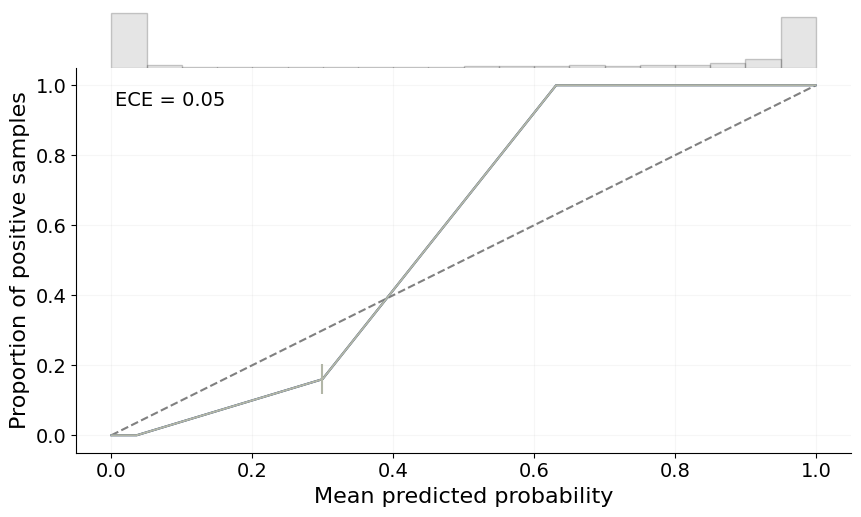

In [295]:
results = pd.read_pickle("results/sst2_context_16_tiiuae_Falcon3-10B-Instruct.pkl")
# Call the function
prob_pos = np.where(results["true_label"] == 1, results["prob"], 1 - results["prob"])
# print(prob_pos)
# print(results["true_label"])
plot_calibration_curve(results["true_label"], prob_pos, "tiiuae/Falcon3-10B-Instruct", n_bins=20, save=False, method="quantile")
expected_calibration_error(results["true_label"], prob_pos, n_bins=20, method="uniform", return_dict=True)


In [292]:
full_results["model_id"].unique()

array(['meta-llama/Llama-3.2-3B-Instruct', 'google/gemma-2-9b-it',
       'tiiuae/Falcon3-10B-Instruct', 'meta-llama/Llama-3.2-1B-Instruct'],
      dtype=object)

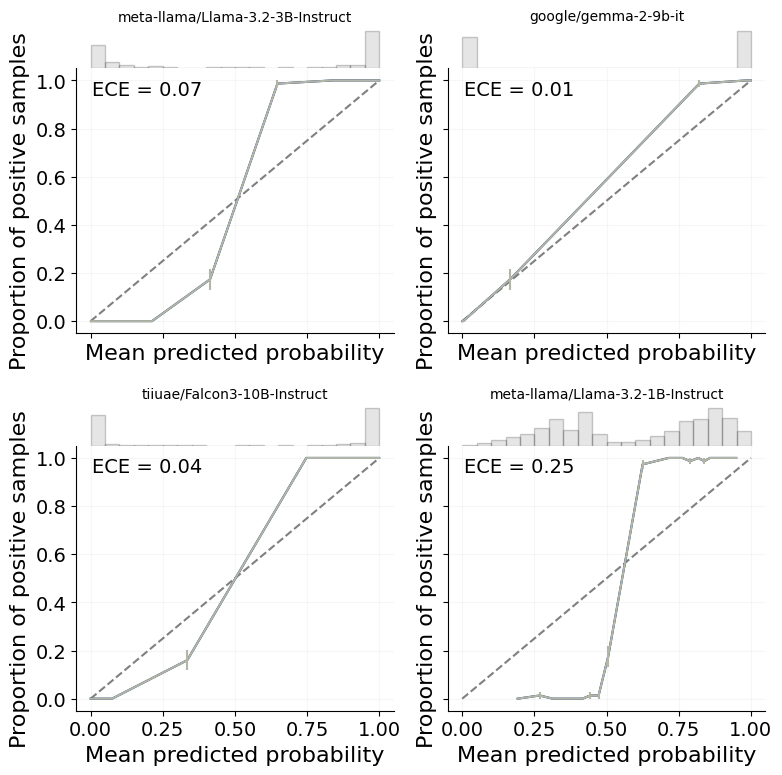

In [305]:
# subplot for each model with n_context = 8
n_context = 4
fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
for i, model_id in enumerate(full_results["model_id"].unique()):
    results = pd.read_pickle(f"results/sst2_context_{n_context}_{model_id.replace('/', '_')}.pkl")
    prob_pos = np.where(results["true_label"] == 1, results["prob"], 1 - results["prob"])
    ax = plot_calibration_curve(results["true_label"], prob_pos, model_id, n_bins=20, save=False, method="quantile", ax=axs[i//2, i%2])
    ax.set_title(model_id, fontsize=10)
plt.tight_layout()
plt.savefig(f"figures/calibration_curves_n_context_{n_context}.pdf")

In [210]:
# unit test
n_bins = 8
y_true = np.array([0, 0, 0, 1, 1, 1, 0, 0, 0, 1])
y_prob_max = np.array([0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91, 1])
# y_prob_max is the probability of the most likely class
# y_prob_pos is the probability of the positive class
y_prob_pos = np.where(y_true == 1, y_prob_max, 1 - y_prob_max)
print(expected_calibration_error(y_true, y_prob_pos, n_bins=8, method="uniform"))
print(calibration_error(torch.tensor(y_prob_pos), torch.tensor(y_true), task="binary", n_bins=8, norm="l1"))
print(bootstrap_ece(y_true, y_prob_pos, ci=0.95, n_bootstraps=1000, n_bins=8, method="uniform"))

# unit test for multiclass
n_bins = 8
y_true = np.array([0, 0, 0, 2, 2, 2, 1, 1, 1, 2])
y_prob = np.array([[0.1, 0.2, 0.7], [0.3, 0.4, 0.3], [0.4, 0.5, 0.1], [0.1, 0.2, 0.7], [0.3, 0.4, 0.3], [0.4, 0.5, 0.1], [0.1, 0.2, 0.7], [0.3, 0.4, 0.3], [0.4, 0.5, 0.1], [0.1, 0.2, 0.7]])
print(expected_calibration_error(y_true, y_prob, n_bins=8, method="uniform", multiclass=True))
# preds tensor needs to be of shape (n_samples, n_classes)
print(calibration_error(torch.tensor(y_prob), torch.tensor(y_true), task="multiclass", num_classes=3, n_bins=8, norm="l1"))


0.44100000000000006
tensor(0.4410, dtype=torch.float64)
[0.27195 0.621  ]
[0.7 0.4 0.5 0.7 0.4 0.5 0.7 0.4 0.5 0.7]
[2 1 1 2 1 1 2 1 1 2]
0.11499999999999999
tensor(0.1500)


In [228]:
# import seaborn as sns

model_ids = ["meta-llama/Llama-3.2-3B-Instruct", "google/gemma-2-9b-it", 
             "tiiuae/Falcon3-10B-Instruct", "mistralai/Mistral-7B-Instruct-v0.3",
             "meta-llama/Llama-3.2-1B-Instruct", "meta-llama/Llama-3.3-70B-Instruct"]  
full_results = []
for model_id in model_ids:
    # for n_context in [16, 32, 64, 128, 256, 512]:
    for n_context in [0, 1, 2, 4, 8, 16, 32, 64]:
        try:
            results = pd.read_pickle(f"results/sst2_context_{n_context}_{model_id.replace('/', '_')}.pkl")
            results["model_id"] = model_id
            results["n_context"] = n_context
            full_results.append(results)
            assert len(results) == 1500, f"Expected 1500 samples, got {len(results)} for {model_id} with {n_context} context samples"
        except FileNotFoundError:
            print(f"File not found for {model_id} with {n_context} context samples")
            continue
        except Exception as e:
            print(e)
full_results = pd.concat(full_results)
full_results["correct"] = full_results["pred"] == full_results["true_label"]
full_results["prob_pos"] = np.where(full_results["true_label"] == 1, full_results["prob"], 1 - full_results["prob"])
# sns.histplot(results["prob"], hue=results["true_label"], multiple="stack")
full_results = full_results.dropna(subset=["pred"])


File not found for mistralai/Mistral-7B-Instruct-v0.3 with 32 context samples
File not found for mistralai/Mistral-7B-Instruct-v0.3 with 64 context samples
File not found for meta-llama/Llama-3.3-70B-Instruct with 0 context samples
File not found for meta-llama/Llama-3.3-70B-Instruct with 1 context samples
File not found for meta-llama/Llama-3.3-70B-Instruct with 2 context samples
File not found for meta-llama/Llama-3.3-70B-Instruct with 4 context samples
File not found for meta-llama/Llama-3.3-70B-Instruct with 8 context samples
File not found for meta-llama/Llama-3.3-70B-Instruct with 16 context samples
File not found for meta-llama/Llama-3.3-70B-Instruct with 32 context samples
File not found for meta-llama/Llama-3.3-70B-Instruct with 64 context samples


In [229]:
ece_results = (
    full_results.groupby(["model_id", "n_context"])
    .apply(
        lambda x: expected_calibration_error(x["true_label"], x["prob_pos"], n_bins=10, method="uniform"),
        include_groups=False,
    )
    .reset_index()
    .rename(columns={0: "ece"})
)
ece_results[["ece_lower", "ece_upper"]] = full_results.groupby(["model_id", "n_context"]).apply(
    lambda x: bootstrap_ece(x.reset_index()["true_label"], x.reset_index()["prob_pos"], ci=0.95, n_bootstraps=1000, n_bins=10, method="uniform"),
    include_groups=False,
).apply(pd.Series).reset_index(drop=True)

google/gemma-2-9b-it
[0.00228708 0.00268137 0.00258852 0.00251249 0.00160337 0.0026669
 0.00406215 0.00289977]
[0.00364354 0.00331132 0.00290302 0.0044185  0.00449197 0.00302295
 0.00435311 0.00301295]
meta-llama/Llama-3.2-1B-Instruct
[0.04531651 0.02162176 0.00766003 0.00820648 0.00815349 0.00821365
 0.00810267 0.00767331]
[0.03372741 0.02400013 0.00931341 0.00839591 0.00811437 0.0085648
 0.00836551 0.00706464]
meta-llama/Llama-3.2-3B-Instruct
[0.00711673 0.00693659 0.00575047 0.00646724 0.00483024 0.00595674
 0.00716418 0.00476694]
[0.00915836 0.00728314 0.00638499 0.00635408 0.00620746 0.00561149
 0.00642089 0.00617457]
tiiuae/Falcon3-10B-Instruct
[0.00546153 0.00491446 0.00543903 0.00452285 0.00508065 0.00536328
 0.00516529 0.00493609]
[0.00587202 0.00498055 0.00532101 0.0045273  0.00488625 0.00599375
 0.00567913 0.00525124]


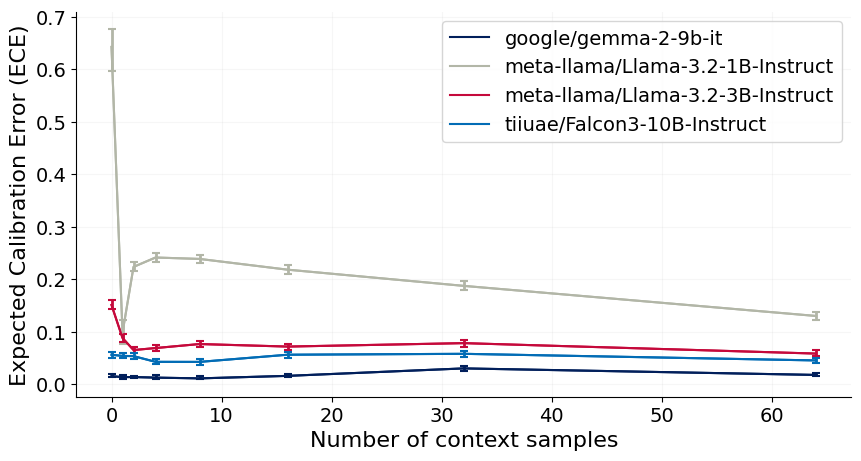

In [241]:
for i, model_id in enumerate(ece_results["model_id"].unique()):
    print(model_id)
    plot_df = ece_results.query("model_id == @model_id")
    plt.plot(plot_df["n_context"], plot_df["ece"], label=model_id, color=wharton_pal[i])
    # plt.fill_between(plot_df["n_context"], plot_df["ece_lower"], plot_df["ece_upper"], alpha=0.4)
    lower = plot_df["ece"].values - plot_df["ece_lower"].values
    print(lower)
    upper = plot_df["ece_upper"].values - plot_df["ece"].values
    print(upper)
    plt.errorbar(plot_df["n_context"], plot_df["ece"], yerr=[lower, upper], elinewidth=2, capsize=3, capthick=1.5, color=wharton_pal[i])
plt.legend()
plt.ylabel("Expected Calibration Error (ECE)")
plt.xlabel("Number of context samples")
plt.savefig("figures/ece_results.pdf")



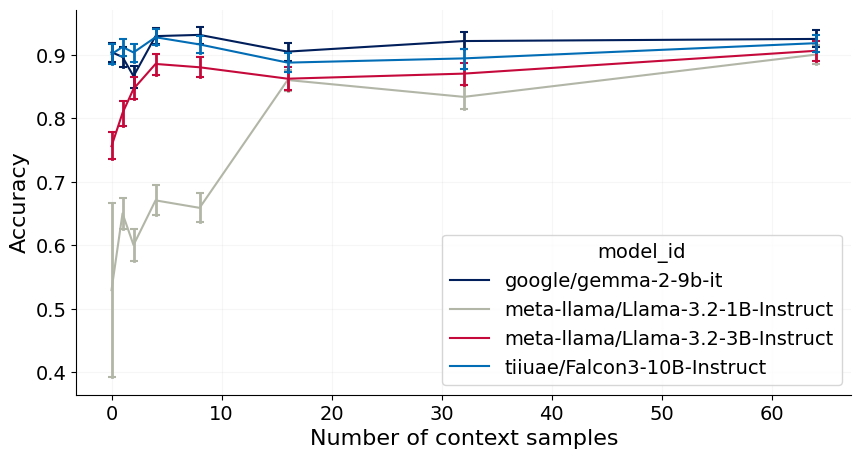

In [243]:
ax = sns.lineplot(data=full_results.reset_index(), x="n_context", y="correct", hue="model_id", hue_order=ece_results["model_id"].unique(),err_style="bars", err_kws={"capsize": 3, "elinewidth": 2, "capthick": 1.5})
ax.set_ylabel("Accuracy")
ax.set_xlabel("Number of context samples")
plt.savefig("figures/accuracy_results.pdf")
